In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
from sklearn.metrics import r2_score
import seaborn as sns
from theano import tensor as tt
from nilearn import datasets
from nilearn.signal import clean
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiLabelsMasker
from sklearn.decomposition import NMF
from nilearn.image import resample_to_img
import nibabel as nib
import arviz as az
import warnings
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations
import matplotlib
from nilearn import plotting, surface
from nilearn import datasets as ds
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.plotting.surface_plotting import plot_surf
from venn import pseudovenn, venn
from venn import generate_petal_labels, draw_venn, generate_colors



Initialize

In [ ]:
export_figures = True
PATH = "..."
scaler = StandardScaler()
imp = SimpleImputer(missing_values=999,strategy="median")

In [2]:
color = ['#3f005c', '#ffa600']
my_colors = []
for c in color:
    my_colors.append(matplotlib.colors.to_rgb(c))

In [ ]:
with hierarchical_all_parcels_education_log_model:
    hierarchical_all_parcels_education_log_trace = pm.load_trace(PATH + "/multimodal_trace.trace")

In [ ]:
mu_left_mean = np.zeros((n_outputs, n_components))
mu_left_sig = np.zeros((n_outputs, n_components))
mu_right_mean = np.zeros((n_outputs, n_components))
mu_right_sig = np.zeros((n_outputs, n_components))
mu_left_reg = np.zeros((n_outputs, n_regions))
mu_right_reg = np.zeros((n_outputs, n_regions))
for i in range(n_outputs):
    for j in range(n_components):
        mu_left = pm.summary(hierarchical_all_parcels_education_log_trace[1000:]["b"+str(i+1)+str(j)][:, 0], hdi_prob=0.90)
        mu_left_mean[i, j] = mu_left.loc[:, 'mean'].values[0]
        mu_left_sig[i, j] =  (mu_left.loc[:, 'hdi_5%'].values[0] *  mu_left.loc[:, 'hdi_95%'].values[0]) > 0
        mu_right = pm.summary(hierarchical_all_parcels_education_log_trace[1000:]["b"+str(i+1)+str(j)][:, 1], hdi_prob=0.90)
        mu_right_mean[i, j] = mu_right.loc[:, 'mean'].values[0]
        mu_right_sig[i, j] =  (mu_right.loc[:, 'hdi_5%'].values[0] *  mu_right.loc[:, 'hdi_95%'].values[0]) > 0

    mu_left_reg[i, :] = nmf.inverse_transform(mu_left_mean[i, :])
    mu_right_reg[i, :] = nmf.inverse_transform(mu_right_mean[i, :])

Venn diagram of significant associatons

<AxesSubplot:>

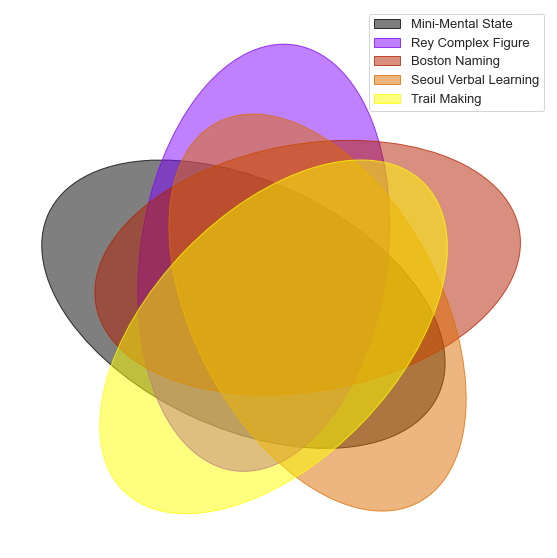

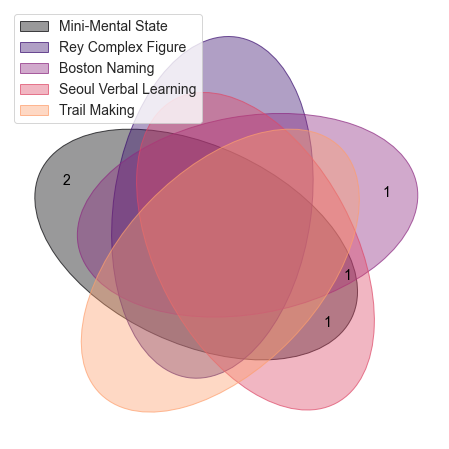

In [ ]:

mu_sig = np.concatenate((mu_left_sig, mu_right_sig), axis=1)
tmp = [np.where(row == 1) for row in mu_sig]

d={}
for i in range(len(cat_names)):
    d[cat_names[i]] = set(tmp[i][0])
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.set_theme(style="white", palette='colorblind', font_scale=2)    
venn(d, cmap= 'gnuplot', alpha=0.5, ax=ax, fmt="", fontsize=13)

# Filter
petal_labels = generate_petal_labels(d.values(), fmt="{size}")
significance_filter = lambda value: value if int(value) > 0 else ""
petal_labels = {
    logic: significance_filter(value)
    for logic, value in petal_labels.items()
}

sns.set_theme(style="white", palette='colorblind', font_scale=1.2)
draw_venn(
    petal_labels=petal_labels, dataset_labels=d.keys(),
    hint_hidden=False, colors=generate_colors(cmap='magma', n_colors=6),
    figsize=(8, 8), fontsize=14, legend_loc="upper left", ax=None
)

(54, 3)


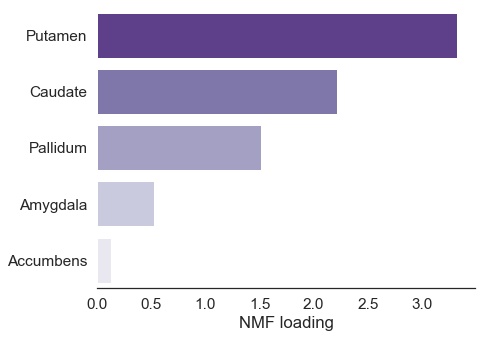

In [ ]:
def map_divergent(X, cmap):
    colors_div = sns.color_palette(cmap, n_colors=100)
    # minmax_scale = MinMaxScaler()
    X_min = np.min(X)
    X_max = np.max(X)
    X_scaled = ((X-X_min)/(X_max-X_min)*99).astype(int)
    clrs = []
    for c in X_scaled:
        clrs.append(colors_div[c])
    return clrs

a = (lesions_collapsed_all.columns)
my_regions = ['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus', 'Inferior Frontal Gyrus\n(pars_triangularis)',
       'Inferior Frontal Gyrus\n(pars opercularis)', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus\n(anterior division)',
       'Superior Temporal Gyrus\n(posterior division)',
       'Middle Temporal Gyrus\n(anterior division)',
       'Middle Temporal Gyrus\n(posterior division)',
       'Middle Temporal Gyrus\n(temporooccipital part)',
       'Inferior Temporal Gyrus\n(anterior division)',
       'Inferior Temporal Gyrus\n(posterior division)',
       'Inferior Temporal Gyrus\n(temporooccipital part', 'Postcentral Gyrus',
       'Superior Parietal Lobule', 'Supramarginal Gyrus\n(anterior division)',
       'Supramarginal Gyrus\n(posterior division)', 'Angular Gyrus',
       'Lateral Occipital Cortex\n(superior division)',
       'Lateral Occipital Cortex\n(inferior division)', 'Intracalcarine Cortex',
       'Frontal Medial Cortex',
       'Juxtapositional Lobule Cortex',
       'Subcallosal Cortex', 'Paracingulate Gyrus',
       'Cingulate Gyrus\n(anterior division)',
       'Cingulate Gyrus\n(posterior division)', 'Precuneous Cortex',
       'Cuneal Cortex', 'Frontal Orbital Cortex',
       'Parahippocampal Gyrus\n(anterior division)',
       'Parahippocampal Gyrus\n(posterior division)', 'Lingual Gyrus',
       'Temporal Fusiform Cortex\n(anterior division)',
       'Temporal Fusiform Cortex\n(posterior division)',
       'Temporal Occipital Fusiform Cortex', 'Occipital Fusiform Gyrus',
       'Frontal Operculum Cortex', 'Central Opercular Cortex',
       'Parietal Operculum_Cortex', 'Planum Polare',
       'Heschl''s Gyrus', 'Planum Temporale',
       'Occipital Pole', 'Thalamus', 'Caudate', 'Putamen', 'Pallidum',
       'Hippocampus', 'Amygdala', 'Accumbens']
var = 8 
x = nmf.components_.T[:, var-1]
idx = np.argsort(-x)
y_lab = np.array([my_regions[idx[i]] for i in range(5)])
cmap = map_divergent(x[idx].T, 'Purples')
print(np.shape(cmap))
sns.set_theme(style="white", palette='colorblind', font_scale=1.4)
fig, ax = plt.subplots(1, figsize=(7, 5))
g = sns.barplot(x[idx[:5]], y_lab, palette='Purples_r', ci=None)
g.set_xlabel('NMF loading')
plt.tight_layout()
sns.despine(left=True)

plt.show()

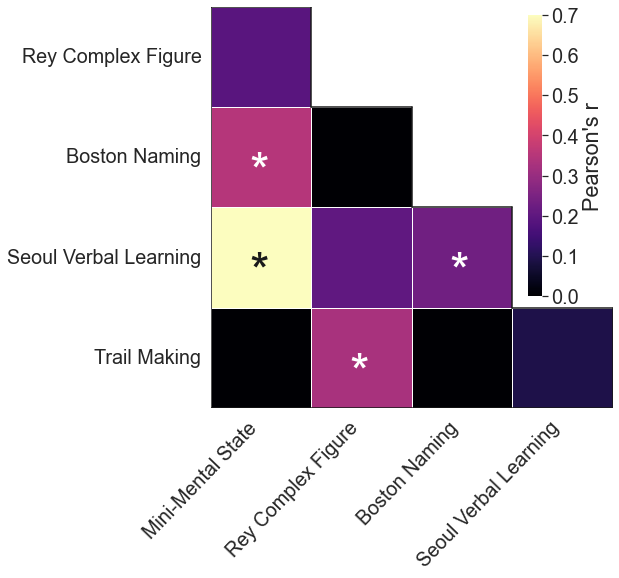

In [ ]:
# Correlation matrix of outcomes
def map_pearson(X, n):
    r = np.zeros((n, n))
    p = np.zeros((n, n))
    for i in range(n-1):
        for j in np.arange(i+1, n):
            r[j, i], p[j, i] = pearsonr(X[i], X[j])
    p_sig, p_adj = fdrcorrection(p[np.tril_indices(p.shape[0], k=-1)])
    p = np.zeros((n, n))
    p[np.tril_indices(p.shape[0], k=-1)] = p_sig
    return r, p


(r, p) = map_pearson(np.abs(np.concatenate((mu_left_reg, mu_right_reg), axis=1)), len(cat_names))
mask = np.triu(np.ones((r.shape[0]-1, r.shape[0]-1)), k=1)
mask_down = np.triu(np.ones((r.shape[0], r.shape[0])), k=0)
mask_up = np.tril(np.ones((r.shape[0], r.shape[0])), k=0)
sns.set_theme(style="white", palette='colorblind', font_scale=1.8)
fig, ax = plt.subplots(1, figsize=(9, 9))
g = sns.heatmap(data=r[1:len(cat_names), 0:(len(cat_names)-1)],
                mask=mask, cbar=True, cmap='magma', linewidths=0.5,
                square=True, annot=False,
                vmin=0, vmax=0.7,
                cbar_kws={'label': "Pearson\'s r", 'shrink': 0.575,
                          'anchor': (-1.8,0.75)})
for i in range(r.shape[0]):
    for j in range(i+1):
        if p[i, j] == 1:
            if np.abs(r[i, j]) > 0.4:
                ax.text(j + 0.475, i - 0.325, '*', color='k', size=50,
                        ha='center', va='center')
            else:
                ax.text(j + 0.475, i - 0.325, '*', color='w', size=50,
                        ha='center', va='center')
n_cubes = r.shape[1]
plt.axhline(y=n_cubes-1, xmin=0, xmax=1, linestyle='-',
            linewidth=1.5, color='k')
plt.axvline(x=0, ymin=0, ymax=1, linestyle='-', linewidth=1.5,
            color='k')
for i in range(n_cubes):
    plt.axhline(y=i, xmin=i*(1/(n_cubes-1)), xmax=(i+1)*1/(n_cubes-1),
                linestyle='-', linewidth=1.5, color='k')
    plt.axvline(x=n_cubes-1-i, ymin=i*(1/(n_cubes-1)),
                ymax=(i+1)*1/(n_cubes-1),
                linestyle='-', linewidth=1.5, color='k')
g.set_xticklabels(cat_names[0:(len(cat_names)-1)], rotation=46,
                  horizontalalignment='right')
g.set_yticklabels(cat_names[1:len(cat_names)], rotation=0)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')
plt.show()

Top inverse projected betas

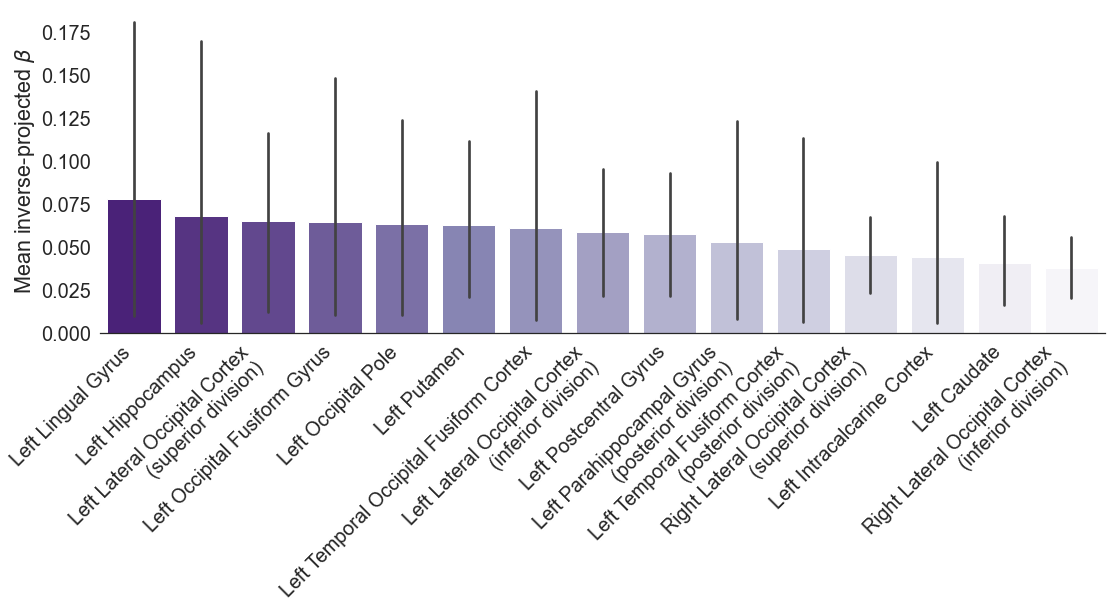

In [ ]:
left_regions = ['Left '+region for region in my_regions]
right_regions = ['Right '+region for region in my_regions]
reduced_regions = np.concatenate((left_regions, right_regions))
x = np.abs(np.concatenate((mu_left_reg, mu_right_reg), axis=1))
idx = np.argsort(-np.mean(x,axis=0))[0:15]
x = x[:, idx]
reduced_regions = reduced_regions[idx]
df = pd.DataFrame(data=x.T, columns=cat_names,
                  index=reduced_regions)
df = pd.melt(df, ignore_index=False)
df = df.reset_index(drop=False)

sns.set_theme(style="white", palette='colorblind', font_scale=1.8)
fig, ax = plt.subplots(1, figsize=(18, 6))
g = sns.barplot(x='index', y='value', data=df, ci=95,
                palette='Purples_r')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_xlabel('')
sns.despine(left=True)
g.set_ylabel('Mean inverse-projected '+r'$\beta$')
plt.show()
